# Advanced Regression Model.
This pytorch model will predict the sale price of the the kaggle dataset.

In [1]:
# Importing necessary libraries
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
import torch
from sklearn.impute import SimpleImputer
import torch.nn as nn 
from tqdm.auto import tqdm
from pathlib import Path

/Users/kushagrakesarwani/Documents/House_Price_Prediction/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

## Dataset

In [3]:
# Constants for data paths
TRAIN_DATA = './kaggle/input/house-prices-advanced-regression-techniques/train.csv'
TEST_DATA = './kaggle/input/house-prices-advanced-regression-techniques/test.csv'

# Loading and inspecting the dataset
house_df = pd.read_csv(TRAIN_DATA)
house_df.set_index('Id', inplace=True)
house_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Removing columns with excessive null values
columns_to_drop= []

print("|    Columns\t|   Null Count\t|")
print("|---------------|---------------|")
for col in house_df.columns:
    null_count = house_df[col].isnull().sum()
    if null_count > 0:
        print(f"| {col} \t| \t{null_count} \t|")
    # Checking if null count is more than 200, then dropping them 
    if null_count > 200:
        columns_to_drop.append(col)

print(f"\nDropping the following {columns_to_drop} since they have more than 200 null values.")
house_df.drop(columns=columns_to_drop, axis=1, inplace=True)

|    Columns	|   Null Count	|
|---------------|---------------|
| LotFrontage 	| 	259 	|
| Alley 	| 	1369 	|
| MasVnrType 	| 	872 	|
| MasVnrArea 	| 	8 	|
| BsmtQual 	| 	37 	|
| BsmtCond 	| 	37 	|
| BsmtExposure 	| 	38 	|
| BsmtFinType1 	| 	37 	|
| BsmtFinType2 	| 	38 	|
| Electrical 	| 	1 	|
| FireplaceQu 	| 	690 	|
| GarageType 	| 	81 	|
| GarageYrBlt 	| 	81 	|
| GarageFinish 	| 	81 	|
| GarageQual 	| 	81 	|
| GarageCond 	| 	81 	|
| PoolQC 	| 	1453 	|
| Fence 	| 	1179 	|
| MiscFeature 	| 	1406 	|

Dropping the following ['LotFrontage', 'Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'] since they have more than 200 null values.


In [5]:
# Analyzing dataset features
nominal_cols= ['MSZoning', 'LandContour', 'Utilities', 
               'LotConfig', 'Neighborhood', 'Condition1', 
               'Condition2', 'BldgType', 'HouseStyle', 
               'RoofStyle', 'RoofMatl', 'Exterior1st', 
               'Exterior2nd', 'Foundation', 'Heating', 
               'Electrical', 'Functional', 'GarageType',
               'SaleType', 'SaleCondition', 'CentralAir']

ordinal_cols= ['Street', 'LotShape', 'LandSlope', 
               'ExterQual', 'ExterCond', 'BsmtQual', 
               'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
               'BsmtFinType2', 'HeatingQC', 'KitchenQual', 
               'GarageFinish', 'GarageQual', 'GarageCond', 
               'PavedDrive']

numerical_cols= house_df.select_dtypes(include=[int, float]).columns.to_list()

## Visualisation

### Numerical Features

In [6]:
# # Removing ordinal features that are numerical in nature
# counter= ['MSSubClass', 'OverallQual', 'OverallCond']
# for item in counter:
#     if item in numerical_cols:
#         numerical_cols.remove(item)

# del(counter)

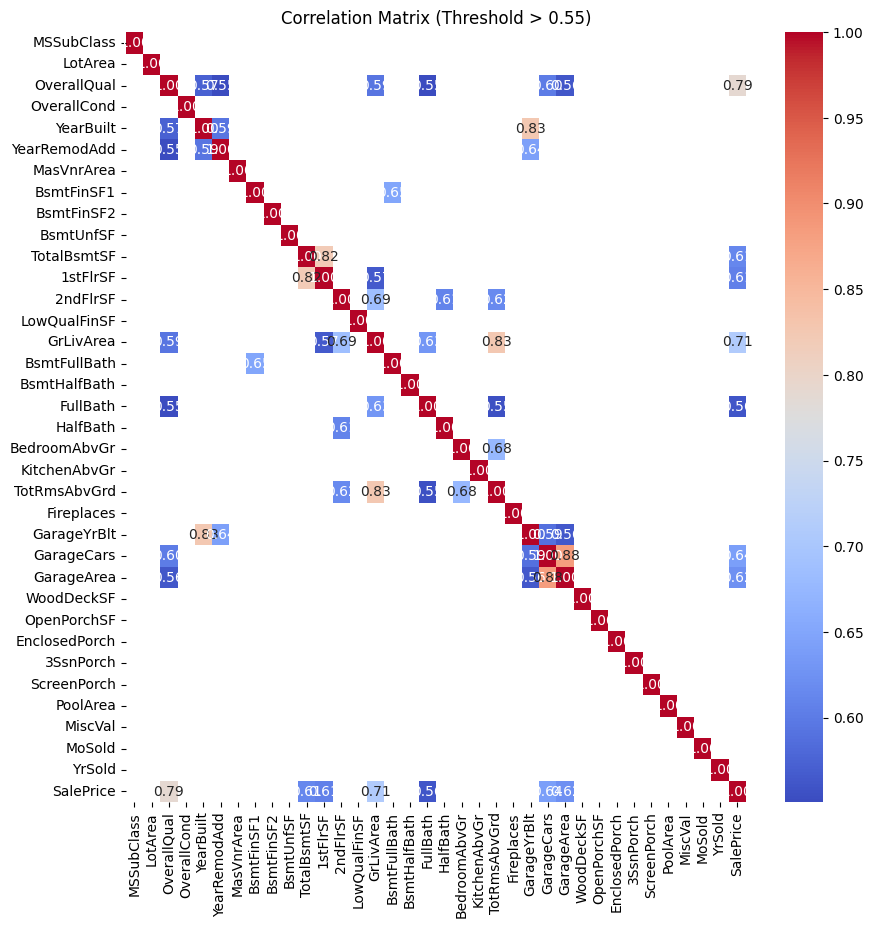

In [7]:
# Calculating and visualizing correlation matrix
threshold = 0.55
corr_matrix = house_df[numerical_cols].corr()
mask = np.abs(corr_matrix) > threshold

plt.figure(figsize=(10, 10))
sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm', mask=~mask, fmt='.2f', cbar=True)
plt.title(f'Correlation Matrix (Threshold > {threshold})')
plt.show()

In [8]:
# Further feature selection based on correlation
selected_num_features = corr_matrix[corr_matrix['SalePrice'].abs() > threshold].index.tolist()
selected_num_features.remove('SalePrice')
selected_num_features

['OverallQual',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'GarageCars',
 'GarageArea']

### Ordinal Features

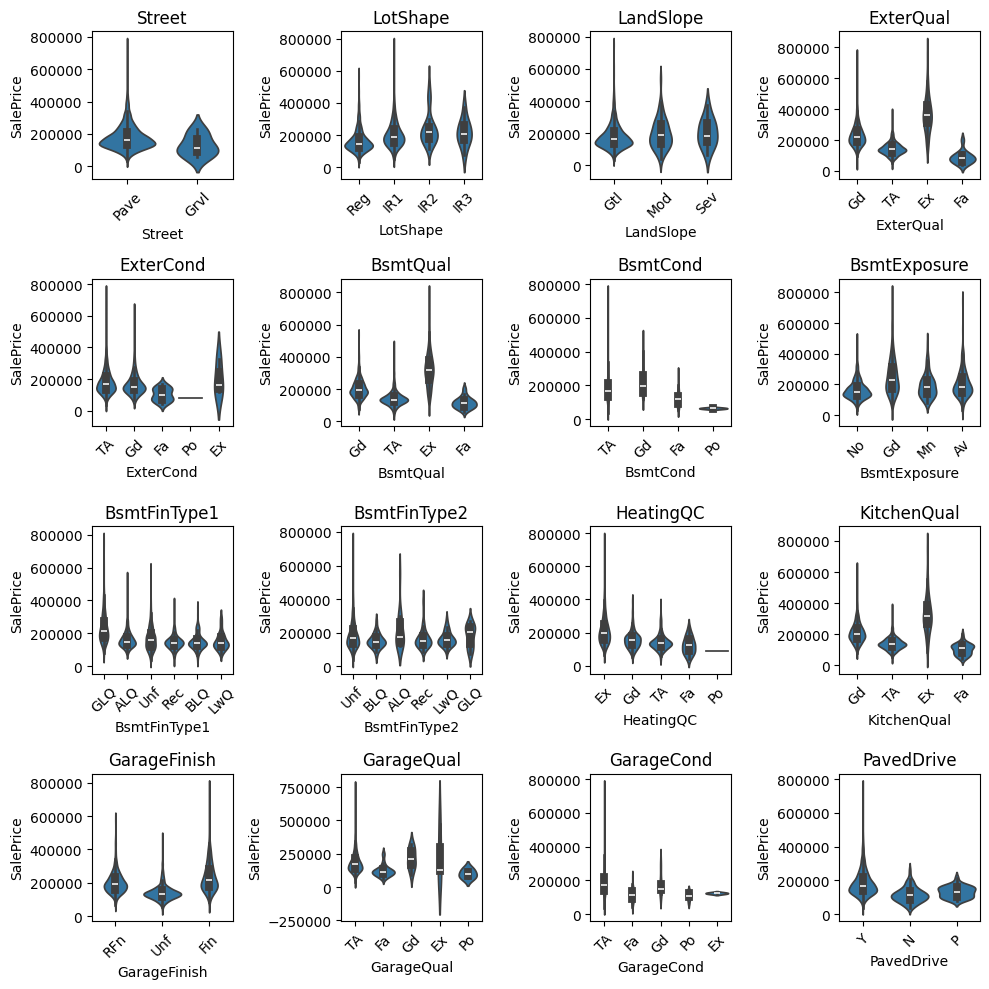

In [9]:
# Visualizing ordinal features against sale price
plt.figure(figsize=(10, 10))
for i, col in enumerate(ordinal_cols, 1):
    plt.subplot(4, 4, i)
    sns.violinplot(data=house_df, x=col, y='SalePrice')
    plt.title(col)
    plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

In [10]:
selected_ord_features=['MSSubClass', 'OverallCond', 'ExterQual', 'HeatingQC', 'KitchenQual', 'PavedDrive']

### Nominal Features

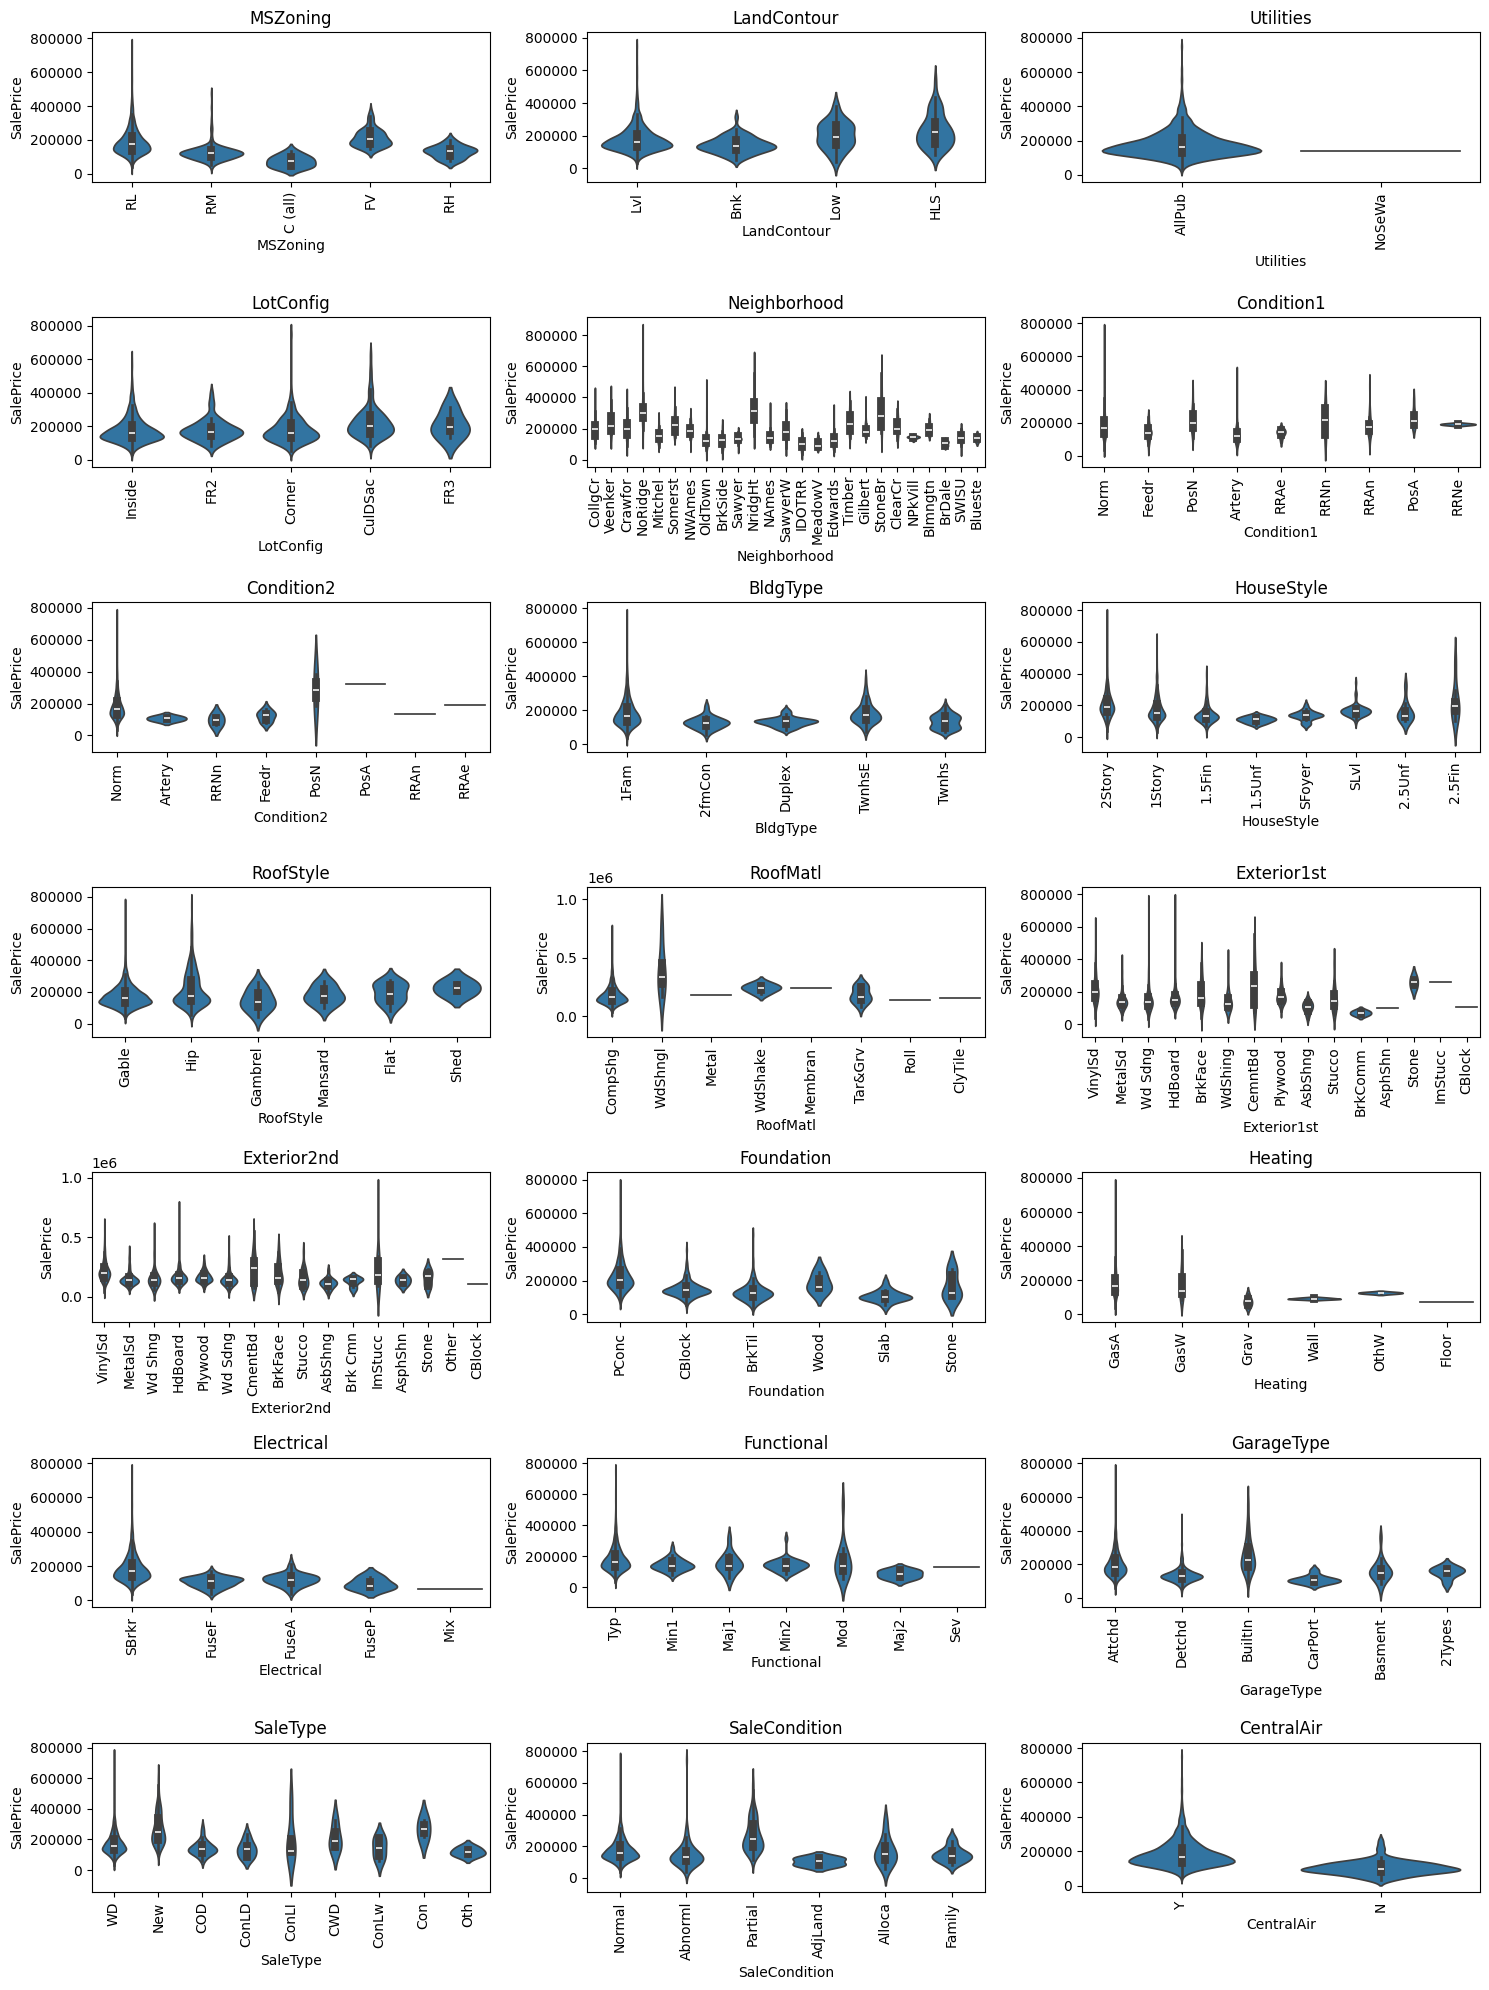

In [11]:
# Visualizing nominal features against sale price
plt.figure(figsize=(15, 20))
for i, col in enumerate(nominal_cols, 1):
    plt.subplot(7, 3, i)
    sns.violinplot(data=house_df, x=col, y='SalePrice')
    plt.title(col)
    plt.xticks(rotation=90)
plt.tight_layout()  
plt.show()

In [12]:
selected_nom_features= ['MSZoning', 'Neighborhood', 'HouseStyle', 'Functional', 'Electrical', 'SaleType']

## Preprocessing

In [13]:
# Data preprocessing and transformation
num_pipeline= Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

# Selecting features for modeling
selected_features = selected_num_features + selected_ord_features + selected_nom_features

# Applying transformations and splitting data for training
X = house_df[list(set(selected_features) & set(house_df.columns))]  # Features
y = house_df.iloc[:, -1]  # Target variable

In [14]:
X.shape

(1460, 19)

In [15]:
X.isna().sum()

PavedDrive      0
OverallCond     0
GarageArea      0
MSZoning        0
OverallQual     0
TotalBsmtSF     0
HouseStyle      0
KitchenQual     0
GarageCars      0
MSSubClass      0
Functional      0
SaleType        0
FullBath        0
Neighborhood    0
1stFlrSF        0
Electrical      1
ExterQual       0
HeatingQC       0
GrLivArea       0
dtype: int64

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_preprocess', num_pipeline, selected_num_features),
        ('ordinal_preprocess', OrdinalEncoder(), selected_ord_features),
        ('nominal_preprocess', TargetEncoder(), selected_nom_features)
    ],
    remainder='passthrough' 
)

# Transforming data into tensors
X_transformed= preprocessor.fit_transform(X, y)
X_tensor= torch.tensor(X_transformed, dtype=torch.float32, device=device)
y_tensor= torch.tensor(y.values, dtype=torch.float32, device=device)

# Train and validtion split
X_train, X_val, y_train, y_val= train_test_split(X_tensor, y_tensor, test_size=0.2, shuffle=True)

# Defining model input and output shapes
in_shape = X_train.shape[1]  # Input shape for the model
out_shape = 1  # Output shape for the model

## Model

In [17]:
class HousePriceRegressor(nn.Module):
    """
    Neural Network model with a configurable number of layers and units.

    Args:
    - input_shape (int): Number of input features.
    - hidden_units (int): Number of units in the hidden layer.
    - output_shape (int): Number of output units.

    Attributes:
    - layer1 (nn.Sequential): Sequential layer comprising Flatten, Linear, ReLU, and Linear layers.
    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        """
        Forward pass through the neural network.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor from the network.
        """
        return self.layer1(x)

In [18]:
model= HousePriceRegressor(input_shape=in_shape, output_shape= out_shape, hidden_units= 256)

## Training

### Loss Function and Optimizer

In [19]:
# Define loss function and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training and Testing Loop

In [20]:
def train_step(model: nn.Module, 
               criterion: nn, 
               optimizer: torch.optim, 
               X: torch.tensor, 
               y: torch.tensor)->float:
    """
    Performs a single training step.

    Args:
    - model (nn.Module): The neural network model.
    - criterion (torch.nn): The loss function.
    - optimizer (torch.optim): The optimization algorithm.
    - X (torch.Tensor): The input data.
    - y (torch.Tensor): The target data.

    Returns:
    - float: The computed loss value.
    """
    optimizer.zero_grad()
    outputs = model(X).squeeze()
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    return loss.item()

In [21]:
def test_step(model: nn.Module, 
              criterion: nn, 
              X: torch.tensor, 
              y: torch.tensor) -> float:
    """
    Performs a single testing step.

    Args:
    - model (nn.Module): The neural network model.
    - criterion (torch.nn): The loss function.
    - X (torch.Tensor): The input data.
    - y (torch.Tensor): The target data.

    Returns:
    - float: The computed loss value.
    """
    with torch.no_grad():
        outputs = model(X).squeeze()
        loss = criterion(outputs, y)
    return loss.item()

In [22]:
def train_model(model: nn.Module, 
                criterion: nn, 
                optimizer: torch.optim, 
                X_train: torch.tensor, 
                y_train: torch.tensor, 
                X_test: torch.tensor, 
                y_test: torch.tensor, 
                num_epochs: int = 10000, 
                device: str = 'cpu') -> list:
    """
    Trains a PyTorch model.

    Args:
    - model (nn.Module): The neural network model.
    - criterion (torch.nn): The loss function.
    - optimizer (torch.optim): The optimization algorithm.
    - X_train (torch.tensor): Training input data.
    - y_train (torch.tensor): Training target data.
    - X_test (torch.tensor): Validation input data.
    - y_test (torch.tensor): Validation target data.
    - num_epochs (int): Number of training epochs. Default is 1000.
    - device (str): Device to perform training. Default is 'cpu'.

    Returns:
    - train_losses (list): List of training losses per epoch.
    - test_losses (list): List of validation losses per epoch.
    """
    train_losses = []
    test_losses = []

    model.to(device)
    model.train()

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        train_loss = 0.0
        test_loss = 0.0

        # Training loop
        optimizer.zero_grad()
        outputs = model(X_train.to(device)).squeeze()
        loss = criterion(outputs, y_train.to(device))
        loss.backward()
        optimizer.step()
        train_loss = loss.item()

        # Testing loop
        with torch.no_grad():
            outputs = model(X_test.to(device)).squeeze()
            test_loss = criterion(outputs, y_test.to(device)).item()
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
    print(f"Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}")
    
    return train_losses, test_losses

In [23]:
train_loss, test_loss= train_model(
    model=model,
    criterion=criterion,
    optimizer= optimizer,
    X_train= X_train,
    y_train= y_train,
    X_test= X_val,
    y_test= y_val,
    num_epochs=50000,
    device= device
)

Training Progress:   0%|          | 0/50000 [00:00<?, ?it/s]/Users/kushagrakesarwani/Documents/House_Price_Prediction/.venv/lib/python3.9/site-packages/torch/autograd/__init__.py:251: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training Progress: 100%|██████████| 50000/50000 [02:48<00:00, 296.59it/s]

Train Loss: 21056.01, Test Loss: 24950.00


## Plotting the loss curves

In [24]:
def plot_losses(train_losses, test_losses):
    """
    Plots the training and test losses.

    Args:
    - train_losses (list): List of training losses per epoch.
    - test_losses (list): List of validation losses per epoch.

    Returns:
    None
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 10))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, test_losses, label='Test Loss', marker='o')
    plt.title('Training and Test Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

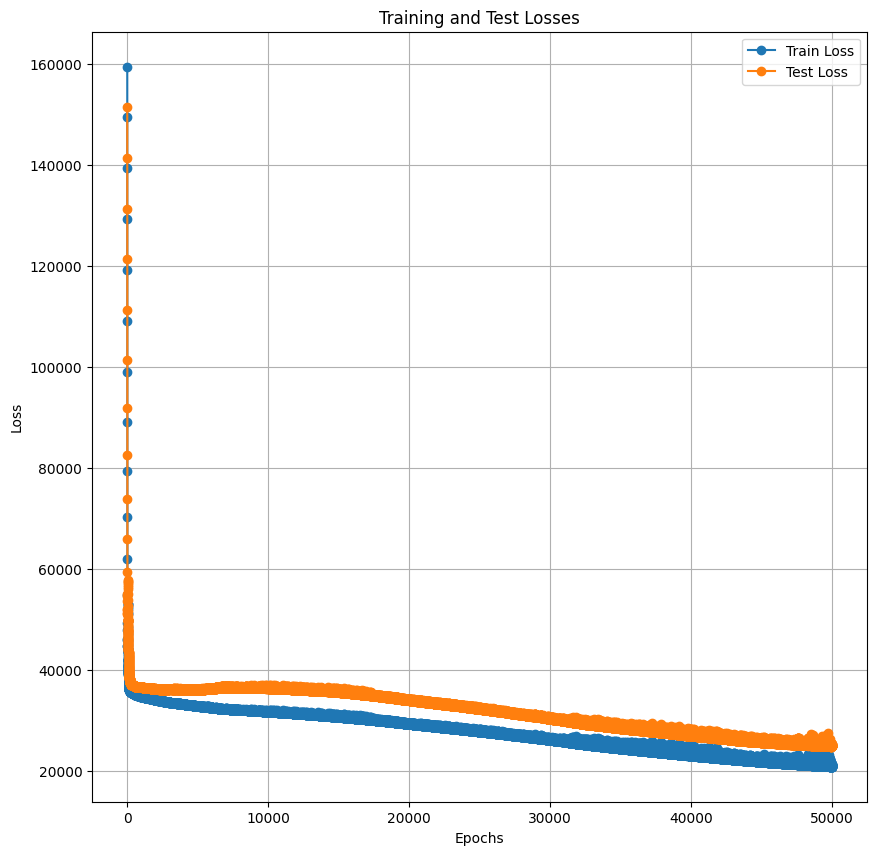

In [25]:
plot_losses(train_loss, test_loss)

## Saving the Model

In [26]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.
  
  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)
  
  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [27]:
MODEL_PATH= 'HousePriceRegressor1_50000_epochs.pth'

save_model(model=model, target_dir='models', model_name= MODEL_PATH)

[INFO] Saving model to: models/HousePriceRegressor1_50000_epochs.pth


In [28]:
loaded_model = torch.load(f'models/{MODEL_PATH}', map_location=device)

## Making Predictions

In [29]:
selected_features.append('Id')

# Importing the selected features for making predictions.
X_test= pd.read_csv(TEST_DATA, usecols= selected_features)
X_test.set_index('Id', inplace=True)

In [30]:
X_test.head()

,MSSubClass,MSZoning,Neighborhood,HouseStyle,OverallQual,OverallCond,ExterQual,TotalBsmtSF,HeatingQC,Electrical,1stFlrSF,GrLivArea,FullBath,KitchenQual,Functional,GarageCars,GarageArea,PavedDrive,SaleType
Id,,,,,,,,,,,,,,,,,,,
1461,20,RH,NAmes,1Story,5,6,TA,882.0,TA,SBrkr,896,896,1,TA,Typ,1.0,730.0,Y,WD
1462,20,RL,NAmes,1Story,6,6,TA,1329.0,TA,SBrkr,1329,1329,1,Gd,Typ,1.0,312.0,Y,WD
1463,60,RL,Gilbert,2Story,5,5,TA,928.0,Gd,SBrkr,928,1629,2,TA,Typ,2.0,482.0,Y,WD
1464,60,RL,Gilbert,2Story,6,6,TA,926.0,Ex,SBrkr,926,1604,2,Gd,Typ,2.0,470.0,Y,WD
1465,120,RL,StoneBr,1Story,8,5,Gd,1280.0,Ex,SBrkr,1280,1280,2,Gd,Typ,2.0,506.0,Y,WD


In [31]:
X_test['MSSubClass'].unique(), X['MSSubClass'].unique()

(array([ 20,  60, 120, 160,  80,  30,  50,  90,  85, 190,  45,  70,  75,
        180,  40, 150]),
 array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
        180,  40]))

In [32]:
common_values = [val for val in X_test['MSSubClass'].unique() if val in X['MSSubClass'].unique()]
X_test['MSSubClass'] = X_test['MSSubClass'].apply(lambda x: x if x in common_values else np.nan)
X_test.dropna(axis=0, inplace=True)

In [33]:
# Transforming new data
X_transformed_new = preprocessor.transform(X=X_test)
X_tensor_new = torch.tensor(X_transformed_new, dtype=torch.float32, device=device)

In [34]:
# Make predictions using the loaded model
loaded_model.eval()
with torch.no_grad():
    predictions = loaded_model(X)

# Convert predictions tensor to numpy array for further analysis or use
predictions_array = predictions.cpu().numpy()

# Create a DataFrame with Sale IDs and predicted Sale Prices
results_df = pd.DataFrame({'Sale_ID': house_df['Id'], 'Predicted_Sale_Price': predictions_array.flatten()})

# Save the DataFrame to a CSV file
results_df.to_csv('predicted_sale_prices.csv', index=False)

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [ ]:
results_df